In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Plot settings
# Seaborn theme
sns.set_theme(style="whitegrid", context="talk")
palette = sns.color_palette("rocket", 12)
suptitle_fontsize = 14
title_fontsize = 14
axis_fontsize = 14
label_fontsize = 14
legend_fontsize = 14


In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [5]:
df["target"].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

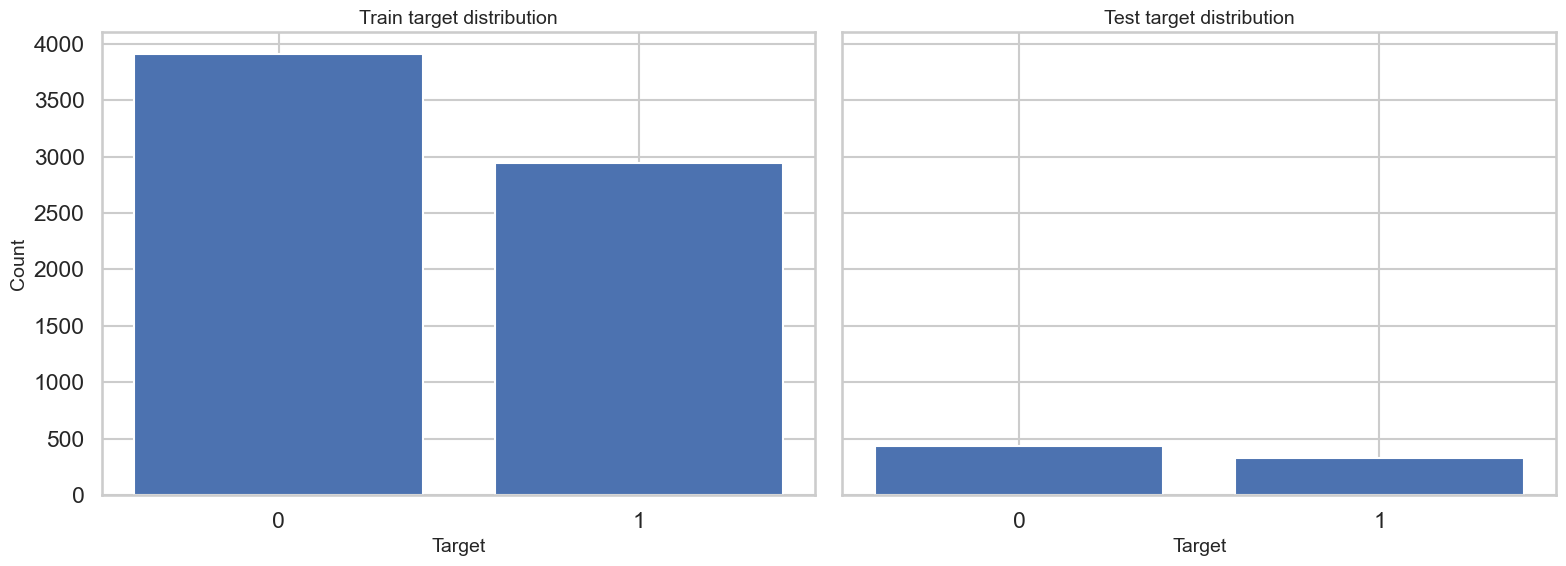

In [9]:
from sklearn.model_selection import train_test_split

# Train/test split
X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=0
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Train subplot
axes[0].bar(y_train.value_counts().index, y_train.value_counts().values)
axes[0].set_title("Train target distribution", fontsize=title_fontsize)
axes[0].set_xlabel("Target", fontsize=label_fontsize)
axes[0].set_ylabel("Count", fontsize=label_fontsize)
axes[0].set_xticks([0, 1])

# Test subplot
axes[1].bar(y_test.value_counts().index, y_test.value_counts().values)
axes[1].set_title("Test target distribution", fontsize=label_fontsize)
axes[1].set_xlabel("Target", fontsize=label_fontsize)
axes[1].set_xticks([0, 1])

plt.tight_layout()
plt.show()


### Dataset Balance
We can see that our dataset is balance is good, since we only have a slight imbalance with class 0 instances being little more than class 1.

In [10]:
X_train = X_train.drop(columns=["id"])
X_train = X_train.fillna("null")
X_train["inputs"] = X_train["keyword"] + " " + X_train["text"]

X_test = X_test.drop(columns=["id"])
X_test = X_test.fillna("null")
X_test["inputs"] = X_test["keyword"] + " " + X_test["text"]

In [11]:
import nltk

nltk.download("wordnet")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zikopis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Preprocessing Steps
* **removeUnicode**: Remove non-standard unicode characters to ensure encoding consistency 
* **replaceUrl**: Replace specific urls with a generic placeholder. This groups all links into a single feature, preventing the model from treating unique URLs as distinct variables.
* **replaceContraction**: Ensures that the words are properly recognized and processed during the later stemming phase.
* **removeEmoticons**: Strip symbols and emoticons to reduce non-alphabetic noise.
* **removeHashtagInFrontOfWOrd**: Remove # symbol from hashtags to extract and retain the underlying keyword.
* **replaceMultiStopMark**: Eliminate repetitive punctuation and special marks that do not contribute semantic value to the task.
* **replaceElongated**: Reduce words with character repetitions to their standard form to ensure they are correctly grouped with their base words.
* **Stemming**: Apply stemming to truncate words to their roots. Stemming is preferred over lemmatization here to aggressively reduce the features and maximize the density of word groupings.

In [12]:
import techniques as techniques

stemmer = techniques.PorterStemmer()

# remove unicode
X_train["inputs"] = X_train["inputs"].apply(lambda x: techniques.removeUnicode(x))
# Replace urls with 'url'
X_train["inputs"] = X_train["inputs"].apply(lambda x: techniques.replaceURL(x))
# Replace contractions , e.g. I'm --> I am
X_train["inputs"] = X_train["inputs"].apply(lambda x: techniques.replaceContraction(x))
# Remove emoticons
X_train["inputs"] = X_train["inputs"].apply(lambda x: techniques.removeEmoticons(x))
# Correct spellings - Comment out due to big calculation time
# X_train["inputs"] = X_train["inputs"].apply(lambda x: techniques.spellCorrection(x))
# Remove hashtags
X_train["inputs"] = X_train["inputs"].apply(
    lambda x: techniques.removeHashtagInFrontOfWord(x)
)
# Remove multiple stop marks
X_train["inputs"] = X_train["inputs"].apply(
    lambda x: techniques.replaceMultiStopMark(x)
)
# Replace elongated words
X_train["inputs"] = X_train["inputs"].apply(lambda x: techniques.replaceElongated(x))
# Apply stemming
X_train["inputs"] = X_train["inputs"].apply(
    lambda t: " ".join(stemmer.stem(w) for w in t.split())
)

# remove unicode
X_test["inputs"] = X_test["inputs"].apply(lambda x: techniques.removeUnicode(x))
# Replace urls with 'url'
X_test["inputs"] = X_test["inputs"].apply(lambda x: techniques.replaceURL(x))
# Replace contractions , e.g. I'm --> I am
X_test["inputs"] = X_test["inputs"].apply(lambda x: techniques.replaceContraction(x))
# Remove emoticons
X_test["inputs"] = X_test["inputs"].apply(lambda x: techniques.removeEmoticons(x))
# Correct spellings - Comment out due to big calculation time
# X_test["inputs"] = X_test["inputs"].apply(lambda x: techniques.spellCorrection(x))
# Remove hashtags
X_test["inputs"] = X_test["inputs"].apply(
    lambda x: techniques.removeHashtagInFrontOfWord(x)
)
# Remove multiple stop marks
X_test["inputs"] = X_test["inputs"].apply(lambda x: techniques.replaceMultiStopMark(x))
# Replace elongated words
X_test["inputs"] = X_test["inputs"].apply(lambda x: techniques.replaceElongated(x))
# Apply stemming
X_test["inputs"] = X_test["inputs"].apply(
    lambda t: " ".join(stemmer.stem(w) for w in t.split())
)


In [13]:
y_train

6669    1
3940    0
7217    0
2234    0
4233    0
       ..
3865    0
6854    1
5669    1
3397    0
2793    1
Name: target, Length: 6851, dtype: int64

In [14]:
import numpy as np

x_train_inputs = np.array(X_train["inputs"])
x_test_inputs = np.array(X_test["inputs"])

### Tf-Idf

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

x_train_tfidf = vectorizer.fit_transform(x_train_inputs)
x_test_tfidf = vectorizer.transform(x_test_inputs)

In [16]:
from sklearn.metrics import classification_report
from sklearn.svm import SVC, LinearSVC

# Train SVM
linear_svc = LinearSVC(random_state=42, max_iter=10000)
linear_svc.fit(x_train_tfidf, y_train)

train_preds = linear_svc.predict(x_train_tfidf)
test_preds = linear_svc.predict(x_test_tfidf)
print("\n\t\tTRAIN SET - LINEAR SVC PERFORMANCE\n")
print(classification_report(y_train, train_preds))
print("\n\t\tTEST SET - LINEAR SVC PERFORMANCE\n")
linear_svc_report = classification_report(y_test, test_preds)
print(linear_svc_report)



		TRAIN SET - LINEAR SVC PERFORMANCE

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      3907
           1       0.98      0.95      0.96      2944

    accuracy                           0.97      6851
   macro avg       0.97      0.97      0.97      6851
weighted avg       0.97      0.97      0.97      6851


		TEST SET - LINEAR SVC PERFORMANCE

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       435
           1       0.79      0.76      0.77       327

    accuracy                           0.81       762
   macro avg       0.81      0.80      0.80       762
weighted avg       0.81      0.81      0.81       762



Here we should pay attention mostly to macro F1-Score, since it provides a trade-off between missing some class predictions and being wrong about others.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)

x_train_pca = pca.fit_transform(x_train_tfidf.toarray())
x_test_pca = pca.transform(x_test_tfidf.toarray())

# LinearSVC
lsvc_pca = LinearSVC(random_state=42, max_iter=10000)
lsvc_pca.fit(x_train_pca, y_train)
lsvc_preds = lsvc_pca.predict(x_test_pca)
print("\n\t\tLinearSVC PERORMANCE (95% PCA)")
linear_svc_pca_scale_report = classification_report(y_test, lsvc_preds)
print(linear_svc_pca_scale_report)

# SVC-gamma='scale'
rbf_svc_gamma_scale = SVC(kernel="rbf", random_state=42)
rbf_svc_gamma_scale.fit(x_train_pca, y_train)
rbf_svc_gamma_scale_preds = rbf_svc_gamma_scale.predict(x_test_pca)
print(
    f"\n\t\tSVC (RBF KERNEL - GAMMA SCALE={rbf_svc_gamma_scale._gamma}) PERORMANCE (95% PCA)"
)
rbf_svc_gamma_scale_report = classification_report(y_test, rbf_svc_gamma_scale_preds)
print(rbf_svc_gamma_scale_report)

# SVC-gamma='auto'
rbf_svc_gamma_auto = SVC(kernel="rbf", random_state=42, gamma="auto")
rbf_svc_gamma_auto.fit(x_train_pca, y_train)
rbf_svc_gamma_auto_preds = rbf_svc_gamma_auto.predict(x_test_pca)
print(
    f"\n\t\tSVC (RBF KERNEL - GAMMA AUTO={rbf_svc_gamma_auto._gamma}) PERORMANCE (95% PCA)"
)
rbf_svc_gamma_auto_report = classification_report(y_test, rbf_svc_gamma_auto_preds)
print(rbf_svc_gamma_auto_report)


		LinearSVC PERORMANCE (95% PCA)
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       435
           1       0.80      0.77      0.79       327

    accuracy                           0.82       762
   macro avg       0.82      0.81      0.81       762
weighted avg       0.82      0.82      0.82       762


		SVC (RBF KERNEL - GAMMA SCALE=1.066897879774353) PERORMANCE (95% PCA
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       435
           1       0.82      0.77      0.79       327

    accuracy                           0.83       762
   macro avg       0.83      0.82      0.82       762
weighted avg       0.83      0.83      0.83       762


		SVC (RBF KERNEL - GAMMA AUTO=0.0002545824847250509) PERORMANCE (95% PCA
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       435
           1       0.00      0.00      0.00       327

 

c:\Users\zikopis\Documents\DWS\DWS_ML\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\zikopis\Documents\DWS\DWS_ML\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\zikopis\Documents\DWS\DWS_ML\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

c:\Users\zikopis\Documents\DWS\DWS_ML\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\zikopis\Documents\DWS\DWS_ML\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\zikopis\Documents\DWS\DWS_ML\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

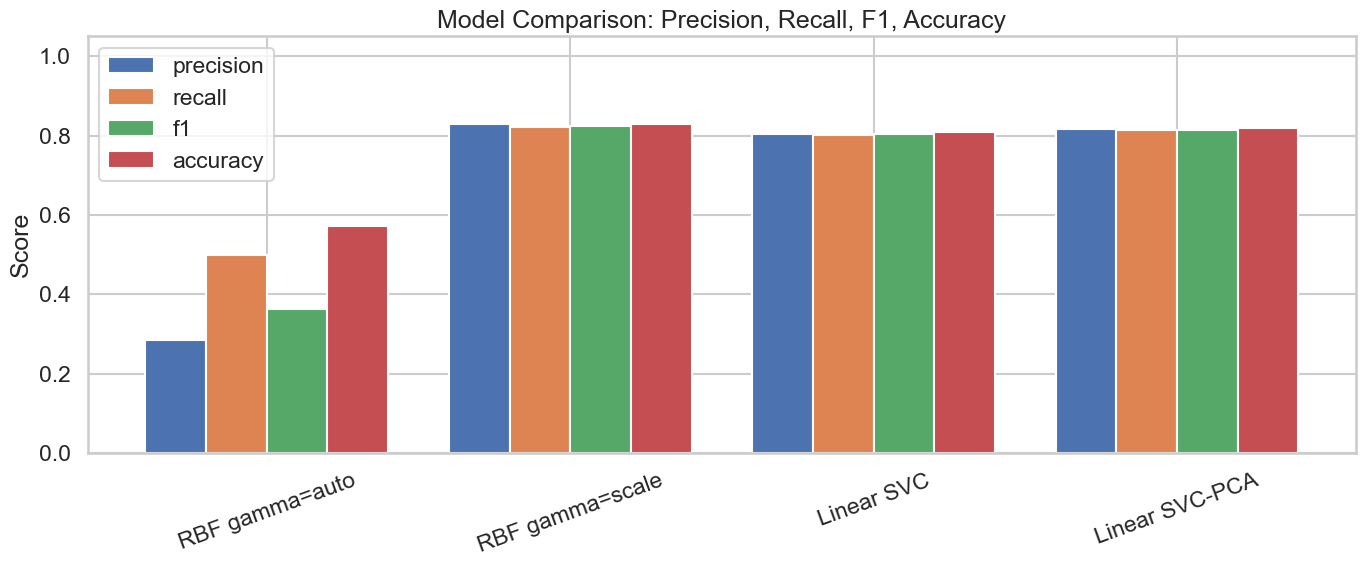

In [ ]:
# Save classification reports as dicts and create a dataframe to plot easier
linear_svc_report = classification_report(y_test, test_preds, output_dict=True)
linear_svc_pca_scale_report = classification_report(
    y_test, lsvc_preds, output_dict=True
)
rbf_svc_gamma_scale_report = classification_report(
    y_test, rbf_svc_gamma_scale_preds, output_dict=True
)
rbf_svc_gamma_auto_report = classification_report(
    y_test, rbf_svc_gamma_auto_preds, output_dict=True
)

reports = {
    "RBF gamma=auto": rbf_svc_gamma_auto_report,
    "RBF gamma=scale": rbf_svc_gamma_scale_report,
    "Linear SVC": linear_svc_report,
    "Linear SVC-PCA": linear_svc_pca_scale_report,
}

rows = []

for model_name, r in reports.items():
    rows.append(
        {
            "model": model_name,
            "precision": r["macro avg"]["precision"],
            "recall": r["macro avg"]["recall"],
            "f1": r["macro avg"]["f1-score"],
            "accuracy": r["accuracy"],
        }
    )

metrics_df = pd.DataFrame(rows)

metrics = ["precision", "recall", "f1", "accuracy"]
x = np.arange(len(metrics_df["model"]))
width = 0.2

plt.figure(figsize=(14, 6))

for i, metric in enumerate(metrics):
    plt.bar(x + i * width, metrics_df[metric], width, label=metric)

plt.xticks(x + width * 1.5, metrics_df["model"], rotation=20)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Model Comparison: Precision, Recall, F1, Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


In [38]:
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB

# Convert matrix to dense
x_train_dense = x_train_tfidf.toarray()
x_test_dense = x_test_tfidf.toarray()

# Train Gaussian NB
gnb = GaussianNB()
gnb.fit(x_train_dense, y_train)

train_preds = gnb.predict(x_train_dense)
test_preds = gnb.predict(x_test_dense)

print("\n\t\tTRAIN SET - GAUSSIAN NB PERFORMANCE\n")
print(classification_report(y_train, train_preds))

print("\n\t\tTEST SET - GAUSSIAN NB PERFORMANCE\n")
gnb_report = classification_report(y_test, test_preds, output_dict=True)
print(classification_report(y_test, test_preds))



		TRAIN SET - GAUSSIAN NB PERFORMANCE

              precision    recall  f1-score   support

           0       1.00      0.83      0.91      3907
           1       0.82      1.00      0.90      2944

    accuracy                           0.90      6851
   macro avg       0.91      0.92      0.90      6851
weighted avg       0.92      0.90      0.90      6851


		TEST SET - GAUSSIAN NB PERFORMANCE

              precision    recall  f1-score   support

           0       0.79      0.49      0.60       435
           1       0.55      0.82      0.66       327

    accuracy                           0.63       762
   macro avg       0.67      0.65      0.63       762
weighted avg       0.68      0.63      0.63       762



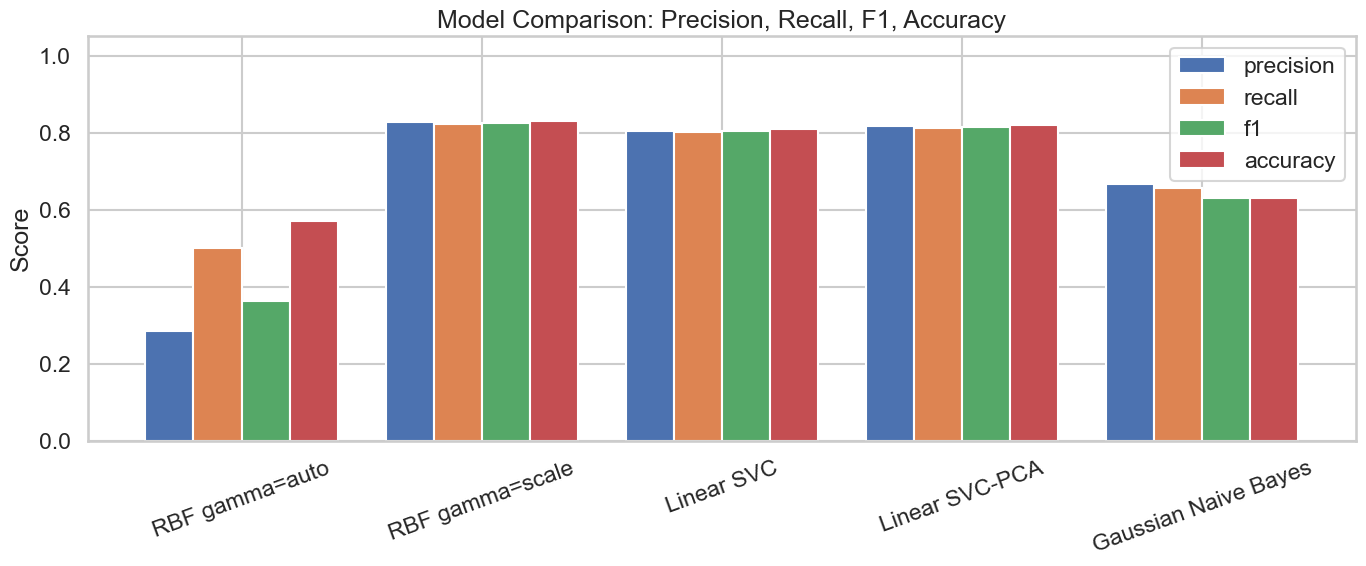

In [39]:
reports = {
    "RBF gamma=auto": rbf_svc_gamma_auto_report,
    "RBF gamma=scale": rbf_svc_gamma_scale_report,
    "Linear SVC": linear_svc_report,
    "Linear SVC-PCA": linear_svc_pca_scale_report,
    "Gaussian Naive Bayes": gnb_report,
}

rows = []

for model_name, r in reports.items():
    rows.append(
        {
            "model": model_name,
            "precision": r["macro avg"]["precision"],
            "recall": r["macro avg"]["recall"],
            "f1": r["macro avg"]["f1-score"],
            "accuracy": r["accuracy"],
        }
    )

metrics_df = pd.DataFrame(rows)

metrics = ["precision", "recall", "f1", "accuracy"]
x = np.arange(len(metrics_df["model"]))
width = 0.2

plt.figure(figsize=(14, 6))

for i, metric in enumerate(metrics):
    plt.bar(x + i * width, metrics_df[metric], width, label=metric)

plt.xticks(x + width * 1.5, metrics_df["model"], rotation=20)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Model Comparison: Precision, Recall, F1, Accuracy")
plt.legend()
plt.tight_layout()
plt.show()
